In [1]:
import math
import os
import sys
sys.path.insert(0,'../src/')
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from experiment import preliminary_setup

In [2]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
register_matplotlib_converters()
FIGURES_DIRECTORY = KWARGS['figure_directory']

# measured battery data
MEASURED_DATA = pd.read_csv(os.path.join(KWARGS['misc_directory'],'battery_electricity_consumption.csv'))
MEASURED_DATA.columns = ['timestamp','building_id','actual_electrical_storage_electricity_consumption']
MEASURED_DATA['timestamp'] = pd.to_datetime(MEASURED_DATA['timestamp'])

# Average daily consumption for all buildings

In [3]:
data_list = []

for k, v in KWARGS['schema']['buildings'].items():
    f = os.path.join(KWARGS['schema']['root_directory'], v['energy_simulation'])
    d = pd.read_csv(f)
    d['Solar Generation [kWh]'] = d['Solar Generation [W/kW]']*v['pv']['attributes']['nominal_power']/1000.0
    d['timestamp'] = MEASURED_DATA['timestamp']
    d['building_id'] = int(k.split('_')[-1])
    data_list.append(d)

simulation_data = pd.concat(data_list, ignore_index=True, sort=False)
simulation_data['hour'] = simulation_data['timestamp'].dt.hour

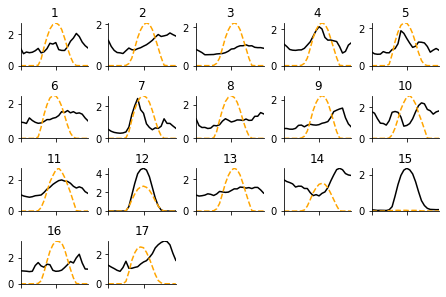

In [39]:
plot_data = simulation_data.groupby(['building_id','hour'])[['Equipment Electric Power [kWh]','Solar Generation [kWh]']].mean().reset_index()
column_count_limit = 5
building_id_count = len(plot_data['building_id'].unique())
row_count, column_count = math.ceil(building_id_count/column_count_limit), min(column_count_limit, building_id_count)
fig, _ = plt.subplots(row_count, column_count, figsize=(1.5*column_count, 1.2*row_count), gridspec_kw={'wspace':0.3, 'hspace':0.7})

for ax in fig.axes[building_id_count:]:
    ax.set_visible(False)

for i, (ax, (b, b_data)) in enumerate(zip(fig.axes, plot_data.groupby(['building_id']))):
    x, y1, y2 = b_data['hour'], b_data['Equipment Electric Power [kWh]'], b_data['Solar Generation [kWh]']
    ax.plot(x, y1, color='black', label='Demand')
    ax.plot(x, y2, color='orange', linestyle='--', label='Generation')
    ax.set_title(b)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.xaxis.set_major_locator(MultipleLocator(12))
    ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_tick_params(labelbottom=None)

    # if i == 0:
    #     ax.legend(
    #         bbox_to_anchor=(0.5,0),
    #         loc='upper center', 
    #         bbox_transform=fig.transFigure,
    #         framealpha=0,
    #         ncol=2
    #     )
    # else:
    #     ax.legend().set_visible(False)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    # if i%column_count == 0:
    #     ax.set_ylabel('kWh')
    # else:
    #     ax.set_ylabel(None)

# fig.align_ylabels()
# plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIRECTORY,f'building_average_daily_load_and_generation_profile.pdf'),bbox_inches='tight',transparent=True)
plt.show()

Figure above shows the average daily electricity demand (black line) and solar generation (dotted orange line) for all 17 buildings at an hourly resolution. It shows the variability in demand across buildings as each building exhibits a unique shape and profile. The buildings also, experience peak load at different times of the day on average with some buildings peaking at midday and others later in the evening. These observations of the building deamnd indicate diversity in occupant behaviour patterns and highlight the need for adaptive control strategies that are able to learn the unique building energy demand patterns.

The time of peak generation does not coincide with the time of peak load in over half of the buildings. Building 15 although installed with PV system, does not generate electricity. Thus, the control policy must learn to charge the batteries during periods of surplus self-generation and discharge during peak times but also, perform efficiently in the absence of supplemental renewable on-site generation.

# Average daily consumption for district

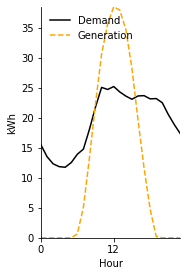

In [26]:
plot_data = simulation_data.groupby(['timestamp', 'hour'])[['Equipment Electric Power [kWh]','Solar Generation [kWh]']].sum().reset_index()
plot_data = plot_data.groupby(['hour'])[['Equipment Electric Power [kWh]','Solar Generation [kWh]']].mean().reset_index()
row_count, column_count = 1, 1
fig, ax = plt.subplots(row_count, column_count, figsize=(2.5*column_count, 4.25*row_count))

x, y1, y2 = plot_data['hour'], plot_data['Equipment Electric Power [kWh]'], plot_data['Solar Generation [kWh]']
ax.plot(x, y1, color='black', label='Demand')
ax.plot(x, y2, color='orange', linestyle='--', label='Generation')
# ax.set_title('District')
ax.set_xlabel('Hour')
ax.set_ylabel('kWh')
ax.xaxis.set_major_locator(MultipleLocator(12))
ax.legend(
    loc='upper left', 
    framealpha=0,
    ncol=1
)

for s in ['right','top']:
    ax.spines[s].set_visible(False)

plt.savefig(os.path.join(FIGURES_DIRECTORY,f'district_average_daily_load_and_generation_profile.pdf'),bbox_inches='tight',transparent=True)
plt.show()